# Make a reasonable dictionary for JumpType 

## imports

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
dict_wn = 'frequency-alpha-wn.txt'
dict_240k = 'frequency-alpha-alldicts.txt'
dict_330k = 'count_1w.txt'
dict_370k = 'words_alpha.txt'

In [4]:
df_wn = pd.read_csv(dict_wn, header=0, delim_whitespace=True, index_col = 0, usecols=[0,1,2], thousands=',', dtype={0:int,1:str,2:np.int64}, na_filter=False)#na_filter avoid 

In [5]:
df_240k = pd.read_csv(dict_240k, header=0, delim_whitespace=True, index_col = 0, usecols=[0,1,2], thousands=',', dtype={0:int,1:str,2:np.int64}, na_filter=False)

In [6]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='#RANKING'>

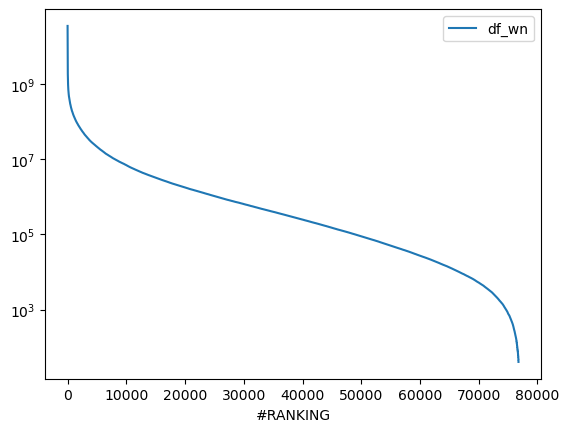

In [7]:
fig, ax = plt.subplots()
# fig.set_size_inches(10,5)
ax.set_yscale('log')
# df_240k.plot(y='COUNT', use_index=True, ax=ax, label='df_240k')
df_wn.plot(y='COUNT', use_index=True, ax=ax, label='df_wn')

<AxesSubplot: xlabel='#RANKING'>

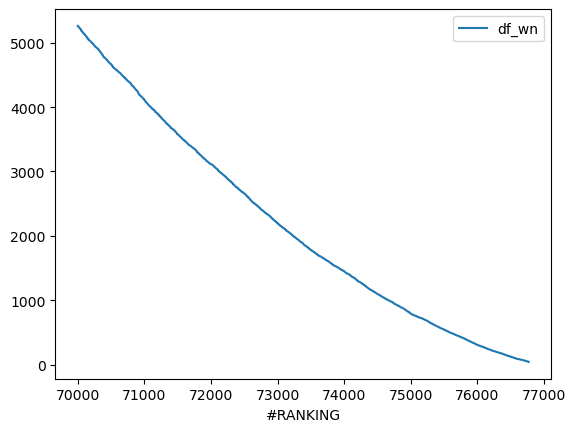

In [8]:
fig, ax = plt.subplots()
# fig.set_size_inches(20,10)
# ax.set_yscale('log')
df_wn[70000:].plot(y='COUNT', use_index=True, ax=ax, label='df_wn')

In [9]:
df_wn.iloc[70000:70100]

,WORD,COUNT
#RANKING,,
70001,playactor,5262
70002,grandstander,5262
70003,misdate,5261
70004,secreter,5259
70005,tuille,5258
...,...,...
70096,Landsmal,5137
70097,Kennedia,5136
70098,unreadably,5135


In [10]:
df_wn.shape

(76769, 2)

In [11]:
df_wn['COUNT'].quantile(0.2)

22701.800000000003

In [12]:
df_wn.iloc[20000]

WORD     mainframe
COUNT      1772017
Name: 20001, dtype: object

## extract proper names

In [13]:
s_capital = df_wn['WORD'].str.contains('[A-Z]',regex=True)

In [14]:
s_capital.values

array([False, False, False, ..., False,  True, False])

In [15]:
df_wn_capital = df_wn[s_capital.values]

Need to find out non standard spellings, i.e. non initial captial letters

In [16]:
for word in df_wn_capital['WORD']:
	if not word[1:].islower():
		print(word)

I
II
O
III
IV
U
CA
VI
USA
MA
UN
IL
VII
NY
PA
UK
DNA
VIII
NA
AIDS
IX
VA
AC
XI
MO
EU
SA
PO
NASA
AB
AR
EPA
USSR
XII
EC
HIV
DOE
OK
IR
WA
XIII
XIV
GA
BA
RA
IA
AA
WI
RNA
ROM
XVI
NATO
CI
IC
IRS
EA
IP
EEC
MIT
NTIS
PE
McGraw
GE
XVIII
XVII
eV
FBI
ABC
USDA
XIX
FDA
RI
DOD
CEO
IMF
IRA
DOS
McCarthy
UNESCO
UV
CIA
CIO
HUD
XXI
ZIP
GAO
FAA
CIS
ATP
AFL
XXII
AZ
VAT
URL
KY
FAO
ALA
LAN
WTO
GI
XXIII
AMP
XXIV
ASEAN
ABS
OD
mRNA
GATT
ANO
OMB
AK
ATM
ICC
ILO
MRI
McCormick
NIH
CAD
OSHA
XXVI
HEW
ABA
McKinley
ACC
IQ
AEC
GPO
GSA
XXVII
AAA
CPU
NOAA
SBA
MacArthur
SAS
EEG
XXVIII
CPI
OPEC
FHA
XXIX
NGO
CPA
EB
UNIX
NAFTA
IgG
ADP
McPherson
SSA
McIntosh
XXXI
GPA
IAEA
FOB
ROI
DEA
DOL
XXXII
RAF
MBA
LEXIS
FORTRAN
USAF
COO
ETA
PLO
ECG
XXXIII
BCE
NOx
FDIC
ASP
FAS
XXXIV
POW
ACTH
cDNA
DBA
ADHD
HMO
NSA
BOD
XXXVI
EDTA
PSA
NAD
NEPA
PEP
UNICEF
OTC
OAS
MacGregor
ELISA
XY
ANOVA
XXXVII
ROC
NASDAQ
LaSalle
NYSE
BMI
MIDI
GABA
CID
GOP
XXXVIII
FEMA
GUI
NARA
IgA
APHIS
ESR
EMU
WY
EAS
IgE
IgM
tRNA
ICAO
UHF
IIS
SOS
USN
ABM
XLI
ISI
McMaster
EOS
TEC

In [18]:
df_wn[df_wn['WORD'].str.contains('muton',False).values]

,WORD,COUNT
#RANKING,,
64378,MUton,14756


In [19]:
df_wn_capital.iloc[15000]

WORD     MUton
COUNT    14756
Name: 64378, dtype: object

In [20]:
df_wn_capital.iloc[10000]

WORD     Achaea
COUNT    120343
Name: 47186, dtype: object

In [21]:
df_wn_capital.iloc[10000:11000]

,WORD,COUNT
#RANKING,,
47186,Achaea,120343
47188,Peewee,120323
47189,Dinesen,120313
47190,Algren,120276
47192,Chaeronea,120262
...,...,...
51023,Lipchitz,80324
51025,Kafkaesque,80322
51029,Rutty,80303


In [22]:
df_wn_lower = df_wn[s_capital.values == False]

delete non-derived rare words

In [23]:
from affixes import prefixes, suffixes

match words that contains these prefixes or suffixes, but the regex pattern may overlap, for example 'y$' and 'ly$' or '^a' and '^ab'. To save time, first compress these pattern to unique ones.

suffix pattern

In [24]:
suffix_pattern = set()
# reverse suffixes and sorted
aux = sorted([suffix[::-1] for suffix in suffixes])
print(aux)

['a', 'aehrr', 'ai', 'aibohp', 'aigahp', 'aigahrr', 'aigelp', 'aigla', 'ailihp', 'aime', 'aimea', 'aimyht', 'ainam', 'ainep', 'ainerhp', 'ainot', 'aipo', 'airu', 'aisahp', 'aisalp', 'aitnodo', 'alliz', 'amaro', 'amo', 'amred', 'amyhcne', 'ana', 'anai', 'arap', 'ca', 'cailihp', 'ci', 'cibohp', 'cif', 'cigol', 'cigre', 'cihport', 'cihprom', 'cihtil', 'cilahpec', 'cilihp', 'ciloha', 'ciloho', 'cimreht', 'cineg', 'cinilc', 'cinoru', 'cio', 'cioz', 'ciport', 'ciprac', 'cir', 'cirtai', 'cirtem', 'cirtnec', 'citarc', 'cite', 'citeiop', 'citeneg', 'cito', 'citsalp', 'citsi', 'cityl', 'da', 'de', 'dep', 'di', 'dif', 'dio', 'diolp', 'dlof', 'dooh', 'dop', 'dra', 'draw', 'ebircs', 'ebohp', 'ecna', 'ecne', 'ecnecse', 'eda', 'edac', 'edep', 'edi', 'edic', 'edici', 'ediw', 'edo', 'edop', 'edut', 'ee', 'ega', 'egahp', 'eguf', 'ei', 'ekil', 'el', 'elad', 'elba', 'elbi', 'elec', 'eleoc', 'eli', 'elihp', 'eliriv', 'elo', 'elu', 'eme', 'emo', 'emord', 'emorhc', 'emos', 'emot', 'emots', 'emyz', 'ena', 'en

In [ ]:
for xiffus in aux:
	if len(xiffus) == 1:
		suffix_pattern.update(xiffus)
	elif xiffus[1]

In [ ]:
df_wn_lower[df_wn_lower['WORD'].str.contains('^'+'|'.join(prefixes),regex=True)]

In [149]:
threshold = 100000
df_wn_lower[(df_wn_lower['COUNT'] <= threshold).values & (df_wn_lower['WORD'].str.contains('ly$',regex=True)).values]

,WORD,COUNT
#RANKING,,
48962,contradictorily,99981
48975,endearingly,99821
48997,redly,99599
49004,stubbly,99538
49021,uncomely,99373
...,...,...
76521,talkily,115
76532,noncomprehensively,112
76542,gainlessly,108


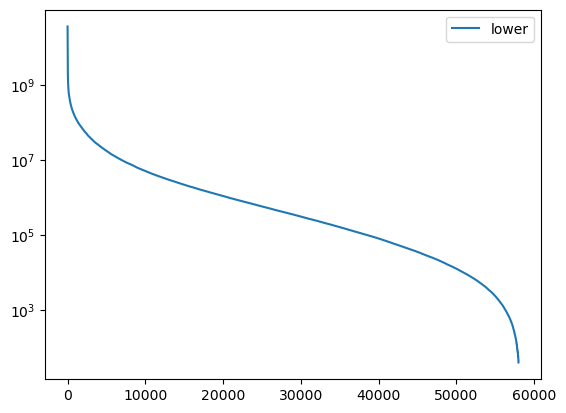

In [87]:
fig, ax = plt.subplots()
# fig.set_size_inches(10,5)
ax.set_yscale('log')
# df_240k.plot(y='COUNT', use_index=True, ax=ax, label='df_240k')
ax.plot(range(df_wn_lower.shape[0]),df_wn_lower['COUNT'].to_numpy(), label='lower')
plt.legend()
# df_wn_lower.plot(x=range(df_wn_lower.shape[0]),y='COUNT',ax=ax)

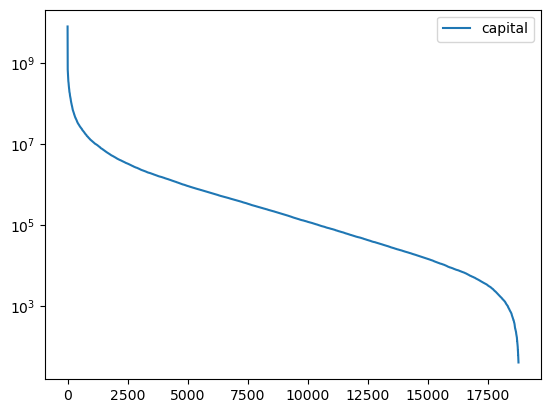

In [89]:
fig, ax = plt.subplots()
# fig.set_size_inches(10,5)
ax.set_yscale('log')
# df_240k.plot(y='COUNT', use_index=True, ax=ax, label='df_240k')
ax.plot(range(df_wn_capital.shape[0]),df_wn_capital['COUNT'].to_numpy(), label='capital')
plt.legend()
# df_wn_lower.plot(x=range(df_wn_lower.shape[0]),y='COUNT',ax=ax)

## clean up wiktionary 

In [5]:
dict_name = 'enwiktionary-latest-all-titles'
dict_cleaned = dict_name+'_cleaned'

In [12]:
with open(dict_cleaned, 'w', encoding='utf-8') as out:
	with open(dict_name, 'r', encoding='utf-8') as f:
		for l in f:
			l = l.strip()
			ls = l.split('\t')
			if len(ls) == 2:
				word = ls[1]
				if word.isalpha() and word.isascii() and len(word) > 4:
					out.write(word+'\n')